# Clustering

Check this [link](https://www.geeksforgeeks.org/clustering-in-machine-learning/) to get an idea of what is clustering in general.

Most of the time we read the clusterring algorithims as a unsupervised learning method, not knowing where it can be used in real world at first. As part of our playground example, we have collected tweets that talks about Data Science/AI. Lets use clustering texhniques to see how the collected data is distributed.

Lets create our own custom Sckilearn transformers and estimators like mentioned [here](https://towardsdatascience.com/custom-transformers-and-ml-data-pipelines-with-python-20ea2a7adb65), the advantage of doing so is that it enables us to resuse our preprocessing and postprocessing logic across data splits and for new data alike.

There is no cluttering of code and the error of missing some or other preprocessing routines. 

## Must Read Topics
- KL Divergence
    - https://towardsdatascience.com/light-on-math-machine-learning-intuitive-guide-to-understanding-kl-divergence-2b382ca2b2a8

**For those who spend more time with Deep Learning, the methods that are been used here, may seem litle strange or loss of information with data preprocessing and dimensionality reduction, and the reason is, most of the ML algorithms depends on statistical and probability nature of the data, less noise the better. Put it simply, most of the ML algorithms takes the advantages of the randomeness and their distribution of the data that really makes sense, and asking machines to fit a mathematical formula for it! and use the formula (model) to predict it. Deep Learning models also does same but with many neurons, thats where the difference lies, ok okay... lets not get into that debate. We have less data and hence no Deep Learning, does that make sense? Ok I heard the conversation/mind voice, we use Twitter stream why less data? basically I am lazy and don't wanna deal huge dataset for educational purpose....hehe**

In [1]:
%load_ext autoreload
%autoreload 2

import os
import glob
import pandas as pd
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import imageio
plt.style.use('ggplot')
import json
import re
import nltk
# nltk.download('punkt')
import spacy
import textacy
import numpy as np
import sys
from tqdm import tqdm, tqdm_notebook
# tqdm.pandas()
sys.path.append("../../../src/")

import random
"""
Its important to set random seed to reproduce the results.
"""
random_state = 42
random.seed(random_state)
np.random.seed(random_state)

from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.pipeline import FeatureUnion, Pipeline 

from ssp.ml.estimator import TextFeatureEngineering
from ssp.ml.transformer import TextPreProcessor
from ssp.ml.transformer import SSPTextLabeler
from ssp.viz.word_cloud import plot_word_cloud

# *Note: some import may not make sense as I may have forgot to remove it as I do more experiments here!

[ssp.ml.estimator]("../../../src/ssp/ml/estimator")   
[ssp.ml.transformer]("../../../src/ssp/ml/transformer") 

In [2]:
TEXT_COL="text"
TEXT_PROCESSED_COL = "text_processed"
TEXT_FEATURE_ENG_COL = "text_num_features"
ssp_LF_dataset = pd.read_parquet("original/ssp_LF_dataset.parquet", engine="fastparquet")

Lets do a wordcloud plot and see what are dominating keywords

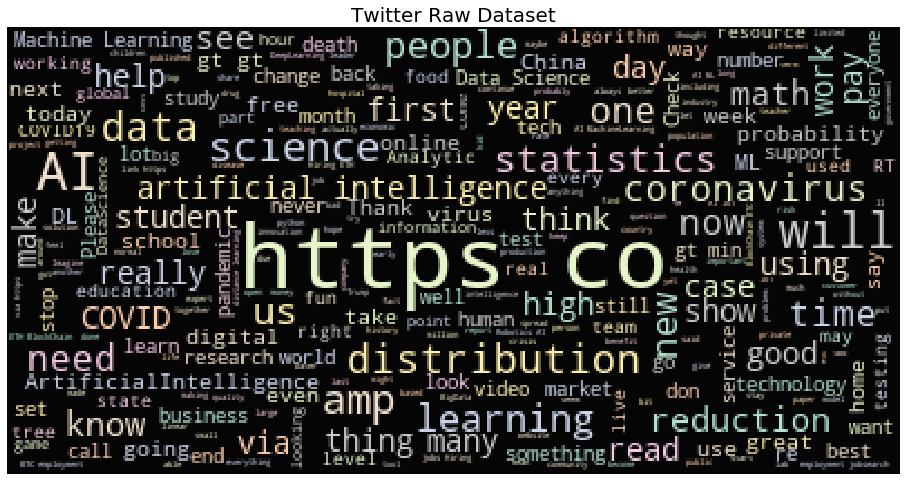

In [3]:
plot_word_cloud(df=ssp_LF_dataset, text_col=TEXT_COL)

Looks like there are lot of http links in the tweets, making it to come up in the top 100 keywords. 
Should we consider "https" and "co" in our vocabalary? can it add some meaning to our text classification?
Both Data Science/AI and other tweets are gonna have this keyword and its not going to be any use!

Then why to keep it, lets remove it. :)

## Data Preprocessing
All our data pre-processing logic is encapsulated under this transformer! Check the source code for more details

In [19]:
text_preprocessor_transformer = TextPreProcessor(input_col=TEXT_COL, output_col=TEXT_PROCESSED_COL)

In [20]:
ssp_LF_dataset = text_preprocessor_transformer.transform(ssp_LF_dataset)
ssp_LF_dataset 

,id,text,text_processed
1500,0,⁦@rahimzmohamed⁩ bored already from working at...,bore work home have little look 1v1 session eb...
1501,1,Top AI Resources - Directory for Remote Learni...,top ai resources directory remote learning luk...
1502,2,@Marshmellowjelo Hi guys.. this one is soo coo...,hi guy soo cool how plan distribution area cov...
1503,3,@CiccioSalvo33 @ISoPonline @EMA_News And knowi...,and know probability overdose paracetamol seri...
1504,4,"Before you reply, perhaps take a minute to do ...",before reply minute math household adult child...
...,...,...,...
2495,995,This is a great article by @joejsmiddleton on ...,this great article change tune coronavirus pro...
2496,996,god my face hurts from laughing at the half li...,god face hurt laugh half life vr ai self aware...
2497,997,ACR outlines 10 priorities to steer federal ov...,acr outline priority steer federal oversight a...
2498,998,.@AHSD25Patton community check this out! @Patt...,ahsd25patton community check conduct live stre...


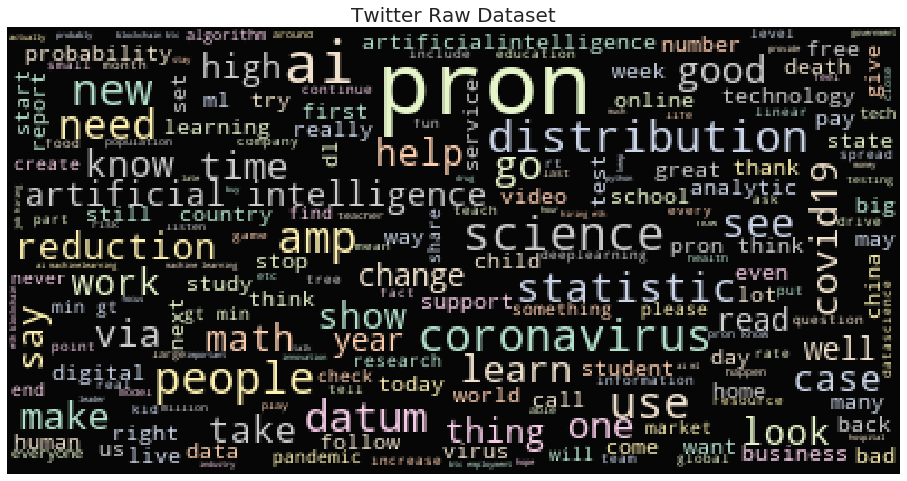

In [39]:
plot_word_cloud(df=ssp_LF_dataset, text_col=TEXT_PROCESSED_COL)

#https://medium.com/reputation-com-datascience-blog/keywords-extraction-with-ngram-and-modified-skip-gram-based-on-spacy-14e5625fce23

## Mannual Tagging Programmatically

Lets label our data based on our prior knowledge of the data, that is if the tweet contains any of pre defined Data SCience/AI 
key words lets consider it talks about AI

In [21]:
ssp_labeler = SSPTextLabeler(input_col=TEXT_PROCESSED_COL)

In [22]:
ssp_LF_dataset = ssp_labeler.transform(ssp_LF_dataset)


0    899
1    101
Name: label, dtype: int64


In [23]:
ssp_LF_dataset[TEXT_PROCESSED_COL].values[0]

'bore work home have little look 1v1 session ebook hope give try finally return training ground'

## Feature Extraction/Engineering

Computer processors needs numeric data, but we have text data with us, so someone has to do the conversion right? Feature engineering is the fancy ;) term that encapsulates some standart methods to convert text data into numeric data and lot of ad-hoc methods to extract meaning full numerica data out of text (for example number of punctuations, number of positive words and negative words, etc.,)

- [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)
![](../../../docs/images/count_vec.png)

```
0 - HIVE
1 - JAVA
2 - SQL
3 - PYTHON

Index: [0, 1, 2, 3]
Doc1 : [2, 0, 0, 1]
Doc2 : [0, 2, 1, 0]
```
More info [here](https://towardsdatascience.com/countvectorizer-hashingtf-e66f169e2d4e)

- [TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)

![](../../../docs/images/tdidf.png)

More info [here](https://towardsdatascience.com/natural-language-processing-feature-engineering-using-tf-idf-e8b9d00e7e76)

In [43]:


text_feature_eng_transformer = TextFeatureEngineering(input_col=TEXT_PROCESSED_COL, 
                                                      output_col=TEXT_FEATURE_ENG_COL,
                                                      vectorizer = "tfidf",
                                                      max_features=4096, 
                                                      ngram_range=(2, 2))

In [44]:
text_feature_eng_transformer = text_feature_eng_transformer.fit(ssp_LF_dataset)
text_numerical_features = text_feature_eng_transformer.transform(ssp_LF_dataset)

In [45]:
text_numerical_features.shape

(1000, 5555)

### Dimensionality Reduction

Now we have extracted enough features for our training, but can we work with such high dimensional data? 
Dependending on the number of records the answer is yes/no. Considering the answer is no, as our systems can't hold huge arrays, lets reduce the features?

But wait? how do we know which one should keep and which should throw away?

Lets give that jobs to dimensionality reductions models/algorithms which can do it in more statistical way.

- [TSNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)

In [46]:
tsne = TSNE(verbose=1, perplexity=30, n_components=2)
text_numerical_features_2_dim = tsne.fit_transform(text_numerical_features)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.110s...
[t-SNE] Computed neighbors for 1000 samples in 9.254s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.240128
[t-SNE] KL divergence after 250 iterations with early exaggeration: 76.067772
[t-SNE] KL divergence after 1000 iterations: 2.210854


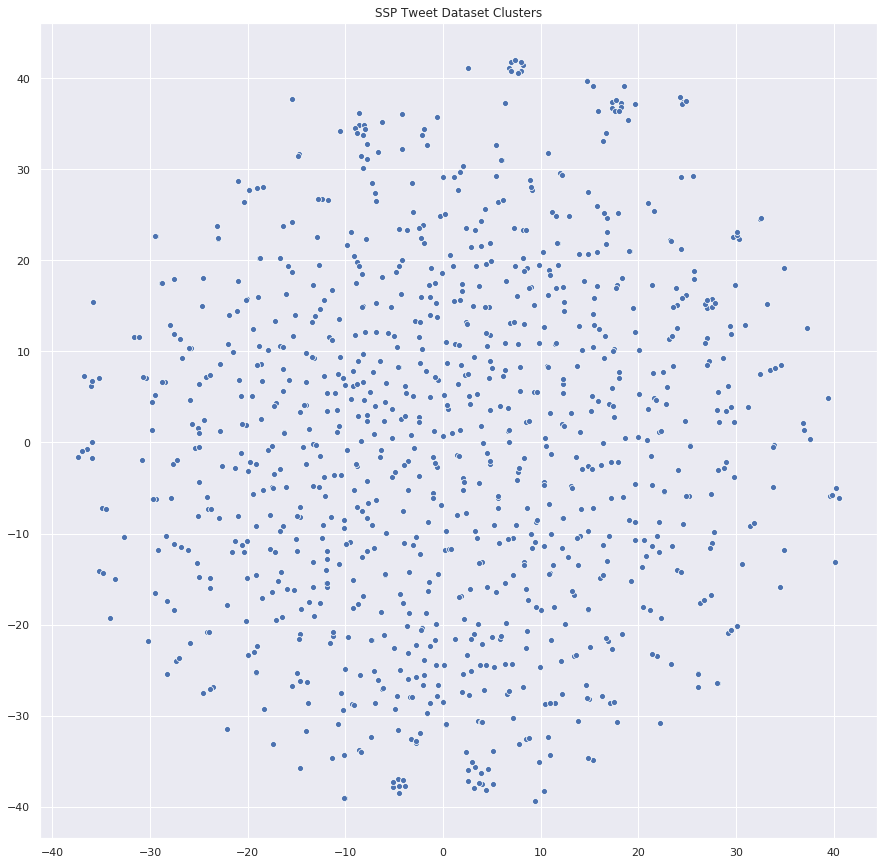

In [47]:
# sns settings
sns.set(rc={'figure.figsize':(15,15)})
# colors
palette = sns.color_palette("bright", 1)
# plot
sns.scatterplot(text_numerical_features_2_dim[:,0], text_numerical_features_2_dim[:,1], palette=palette)
plt.title("SSP Tweet Dataset Clusters")
plt.show()

 - PCA

In [62]:
# reduce the features to 2D
pca = PCA(n_components=2, random_state=random_state)
pca_features = pca.fit_transform(text_numerical_features)

# reduce the cluster centers to 2D
pca_reduced_features = pca.transform(text_numerical_features)


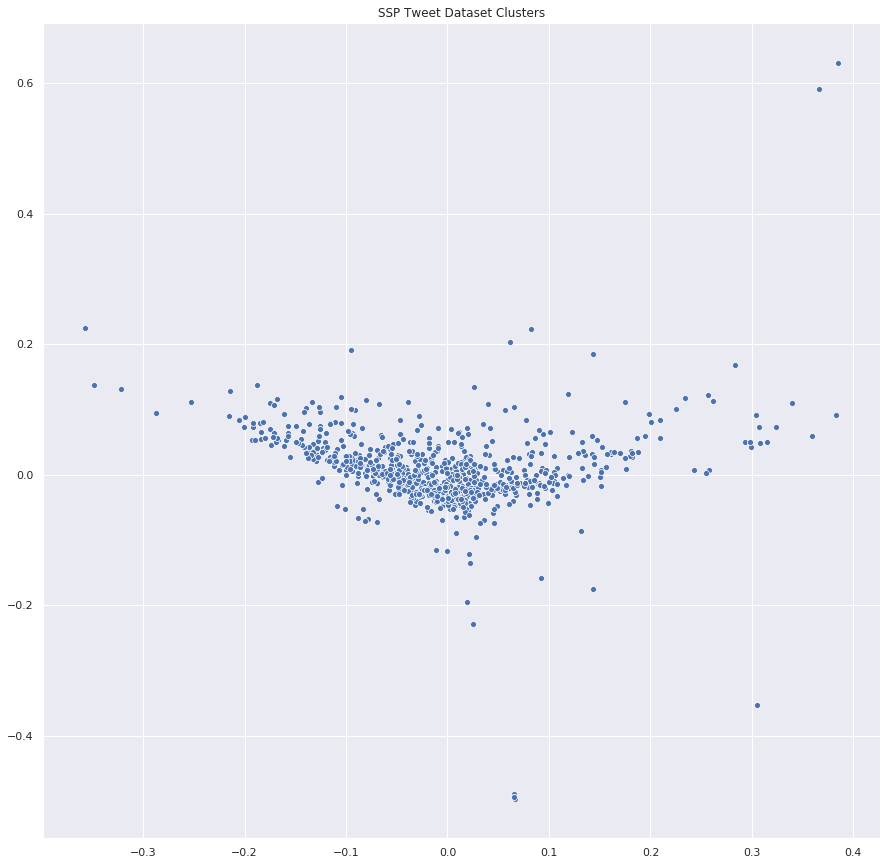

In [63]:
# sns settings
sns.set(rc={'figure.figsize':(15,15)})
# colors
palette = sns.color_palette("bright", 1)
# plot
sns.scatterplot(pca_reduced_features[:,0], pca_reduced_features[:,1], palette=palette)
plt.title("SSP Tweet Dataset Clusters")
plt.show()

In [48]:
# LDA

## KMeans
- https://www.geeksforgeeks.org/k-means-clustering-introduction/

In [56]:
k = 2
kmeans = KMeans(n_clusters=k, init='k-means++', n_jobs=4, verbose=10)
y_pred = kmeans.fit_predict(text_numerical_features)
kmeans _clusters = kmeans.cluster_centers_

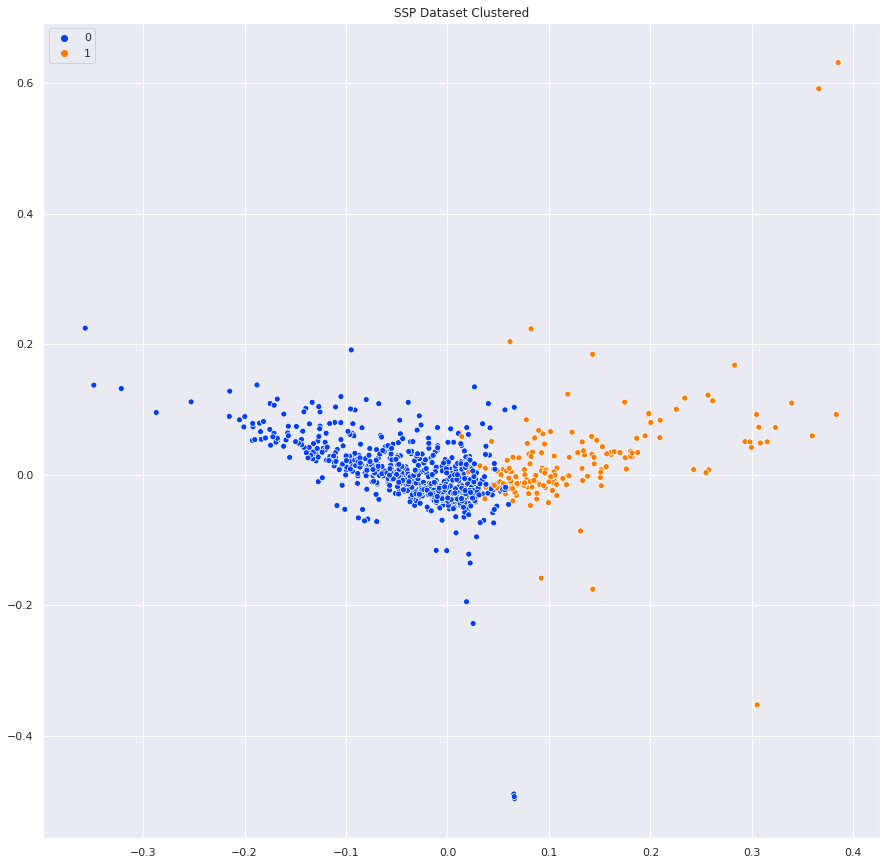

In [64]:
# sns settings
sns.set(rc={'figure.figsize':(15,15)})
# colors
palette = sns.color_palette("bright", len(set(y_pred)))
# plot
sns.scatterplot(pca_reduced_features[:,0], pca_reduced_features[:,1], hue=y_pred, legend='full', palette=palette)
plt.title("SSP Dataset Clustered")
plt.show()

In [ ]:
# sns settings
sns.set(rc={'figure.figsize':(15,15)})
# colors
palette = sns.color_palette("bright", len(set(y_pred)))
# plot
sns.scatterplot(text_numerical_features_2_dim[:,0], text_numerical_features_2_dim[:,1], hue=y_pred, legend='full', palette=palette)
plt.title("SSP Dataset Clustered")
plt.show()

In [58]:
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
# order_centroids[0, :10]

In [59]:
terms = text_feature_eng_transformer.get_feature_names()
for i in range(2):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind]),
    print

Cluster 0:
 pron
 science
 distribution
 people
 coronavirus
 know
 datum
 learn
 need
 use
Cluster 1:
 ai
 artificialintelligence
 machinelearning
 ml
 deeplearning
 robotics
 iot
 blockchain
 follow
 bigdata


In [ ]:
plt.scatter(reduced_features[:,0], reduced_features[:,1], c=cls.predict(features))
plt.scatter(reduced_cluster_centers[:, 0], reduced_cluster_centers[:,1], marker='x', s=150, c='b')


In [54]:
# terms

In [20]:
# LDA -> KMeans

In [21]:
# Clustering Validation Metrics
# siloutte score
# perplexicity 

**References**
- https://www.kaggle.com/maksimeren/covid-19-literature-clustering
- Understanding a bit of precision and recall is very important for the classification
    - https://towardsdatascience.com/precision-vs-recall-386cf9f89488
    - https://medium.com/@mlengineer/generative-and-discriminative-models-af5637a66a3

In [3]:
from sklearn.model_selection import train_test_split


In [26]:
x1,x2 = train_test_split(ssp_LF_dataset, test_size=100, stratify=ssp_LF_dataset["label"])

In [28]:
x1["label"].value_counts(), x2["label"].value_counts()

(0    809
 1     91
 Name: label, dtype: int64, 0    90
 1    10
 Name: label, dtype: int64)

https://towardsdatascience.com/the-magic-of-stratification-in-data-analysis-f1ee4800a283